In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
repo_dir = Path('../..')

In [4]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, set_ticks, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [5]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [6]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [7]:
analysis_dir = repo_dir / 'analysis'
config_dir = analysis_dir / 'curve_fitting/configs/model'
results_dir = analysis_dir / 'curve_fitting/fitting_results'

In [8]:
arch_family = [
    'ResNet',
    'EfficientNet',
    'ConvNeXt',
    'ViT'
]

benchmark_types = ['avg']

In [9]:
all_configs = {}

for arch, b_type in product(arch_family, benchmark_types):
    arch = arch.lower()
    yaml_config = config_dir / f'{arch}/{arch}_{b_type}.yaml'
    all_configs[f"{arch}_{b_type}"] = load_yaml(yaml_config)


In [10]:
L_fit_dict = {key: config['fitting_parameters']['loss_function'] for key, config in all_configs.items()}
L_viz_dict = {key: config['visualization']['loss_function'] for key, config in all_configs.items()}
x_scale_dict = {key: float(config['fitting_parameters']['X_scaler']) for key, config in all_configs.items()}



## Apply Data Filters

In [11]:
all_df = {
    name: apply_filters(df_results, config.get('data_filters', {}))
    for name, config in all_configs.items()
}

## Load Fitting Results

In [12]:
optimized_params_dict = {}
opt_params_boot_dict = {}

for exp_name in all_configs.keys():
    with open(results_dir / f'model_{exp_name}' / 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    L_fit = L_fit_dict[exp_name]
    L_viz = L_viz_dict[exp_name]
    optimized_params_dict[exp_name] = convert_loss_parameters(results['optimized_parameters'], L_fit, L_viz)

    # Convert bootstrapped parameters
    opt_params_boot = results['optimized_parameters_bootstrapped']
    opt_params_boot_dict[exp_name] = convert_loss_parameters_batch(
        params=opt_params_boot,
        src_loss=L_fit,
        dst_loss=L_viz
    )

## Visualize

#### Plotting settings

In [13]:
x_extend = 1.1
X_str = r'$$\tilde{C}$$'
linewidth = 3.0
alpha_scatter = 0.2
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.75
figsize = (10, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palaette = COLOR_PALETTES['models']
arch2colorid = {
    'ResNet': 5,
    'EfficientNet': 4,
    'ConvNeXt': 2,
    'ViT': 3
}

#### Plot

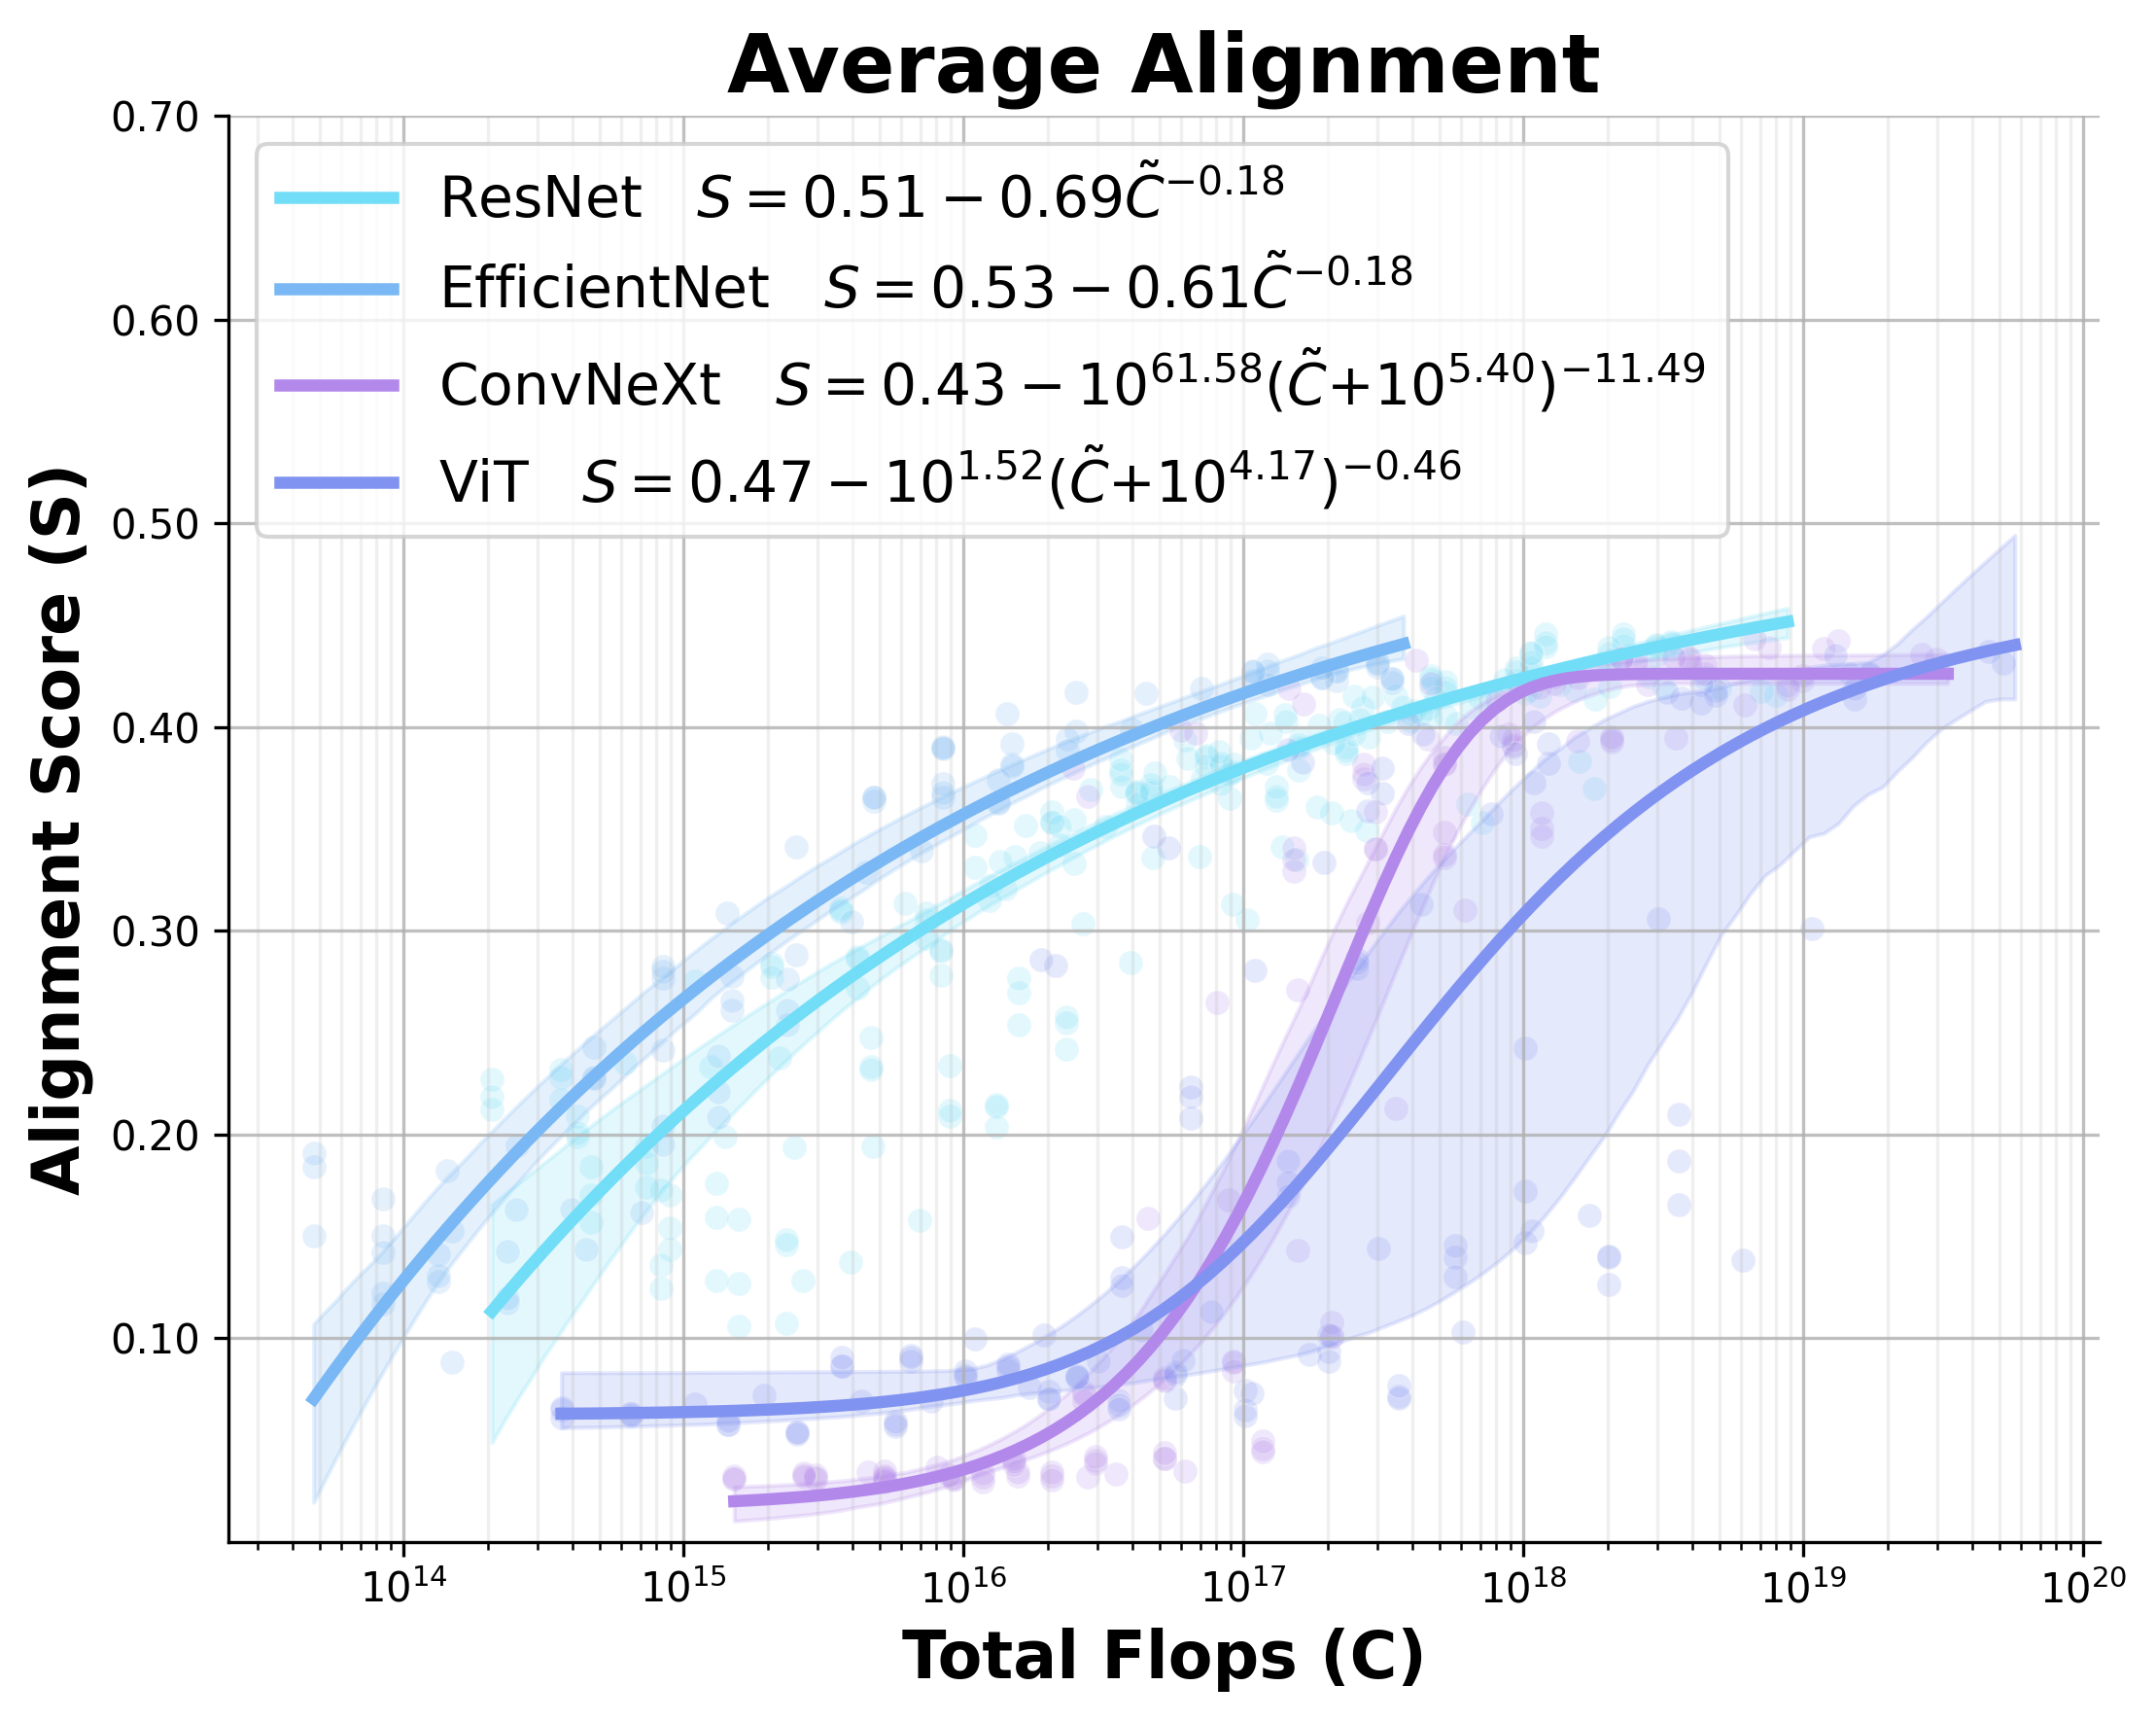

In [14]:

# sns.set_theme(style='whitegrid')
# sns.set_theme(style='ticks')


fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)
ax = axes
for idx, arch in enumerate(arch_family):

    exp_name = f'{arch.lower()}_avg'
    df_region = all_df[exp_name]
    optimized_params_neuro = optimized_params_dict[exp_name]
    opt_params_boot_neuro = opt_params_boot_dict[exp_name]
    L = LOSS_FUNCTIONS[L_viz_dict[exp_name]]
    x_scaler = x_scale_dict[exp_name]
    X = df_region.total_flops.values / x_scaler
    
    color = color_palaette[arch2colorid[arch]]
    sns.scatterplot(data=df_region, x='total_flops', y='score', ax=ax, color=color, alpha=alpha_scatter)
    plot_reg(X, optimized_params_neuro, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=False, alpha=alpha_fit)
    plot_confidence_intervals(X, opt_params_boot_neuro, L, ax, color=color, x_extend=x_extend, x_scaler=x_scaler, alpha=alpha_ci, percentile=95.0, invert_y=True)


### Formatting
ax.set_xscale('log')
ax.set_ylim(0, 0.5)
ax.set_xlabel('FLOPs')
ax.set_ylabel('Alignment')
ax.set_xlabel('Total Flops (C)', fontsize=16, fontweight='bold')
ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
ax.set_title('Average Alignment', fontsize=20, fontweight='bold')
ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

### Legend
handles, labels = ax.get_legend_handles_labels()
labels = [arch + '   ' + l for arch, l in zip(arch_family, labels)]
ax.legend(handles, labels, loc='upper left', fontsize=14, title=None, title_fontsize=16)

ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()


figures_dir = '../figures'
fig_name = 'fig2_compute_arch_avg'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)